In [68]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re

# DXT Darshan logs

Darshan logs do not use tabs to separate fields but this script requires it. To transform multiple spaces into tabs use:

`sed -i 's/ \+ /\t/g' *.dxt.log`

In [72]:
application_name = "warpx"
postfix_name = ".collision"
darshan_file = "../%s/darshan/%s%s.dxt.log" %(application_name, application_name, postfix_name)

## Read the Darshan log

In [73]:
def get_accessed_files(file):
    inf = open(file)
    file_list = []
    cfile = 0
    for line in inf:
        if "DXT, file_id:" in line:
            cfile = line[50:-1]
        if "DXT, write_count:" in line:
            access_cnt = sum([int(i) for i in re.findall(r'\d+', line)])
            file_list += [cfile] * access_cnt
    inf.close()
    return file_list

In [74]:
df = pd.read_csv(darshan_file, delimiter='\t', comment='#',
                 names=["Module", "Rank", "IOType", "Segment", "Offset",
                        "Length", "Start", "End"])
# Add information about the added files
df["File"] = get_accessed_files(darshan_file)
# Filter out entries with length 0
df = df[df.Length > 0]
df.head()

,Module,Rank,IOType,Segment,Offset,Length,Start,End,File
0,X_POSIX,0,read,0,0,1928,0.0546,0.0546,pfs/alpine/csc143/proj-shared/againaru/warpx/w...
1,X_POSIX,0,write,0,0,86,3.3992,3.3993,pfs/alpine/csc143/proj-shared/againaru/warpx/w...
2,X_POSIX,0,write,1,86,36864,3.3994,3.4005,pfs/alpine/csc143/proj-shared/againaru/warpx/w...
3,X_POSIX,0,write,0,0,496,3.4022,3.4022,pfs/alpine/csc143/proj-shared/againaru/warpx/w...
4,X_POSIX,0,write,0,0,33,3.4245,3.4245,pfs/alpine/csc143/proj-shared/againaru/warpx/w...


In [75]:
# Unique files and number of accesses
df.groupby(['File', 'IOType'])["Module"].count()

File                                                                                                           IOType
fs/alpine/csc143/proj-shared/againaru/warpx/warpx/submit_summit/diags/diag100020/ion/Level_0/Particle_H        write      1
fs/alpine/csc143/proj-shared/againaru/warpx/warpx/submit_summit/diags/diag100050/electron/Level_0/DATA_00000   write      4
fs/alpine/csc143/proj-shared/againaru/warpx/warpx/submit_summit/diags/diag100110/Level_0/Cell_H                write      1
fs/alpine/csc143/proj-shared/againaru/warpx/warpx/submit_summit/diags/diag100120/warpx_job_info                write     54
fs/alpine/csc143/proj-shared/againaru/warpx/warpx/submit_summit/diags/diag100130/ion/Header                    write      1
                                                                                                                         ..
pfs/alpine/csc143/proj-shared/againaru/warpx/warpx/submit_summit/diags/diag100140/warpx_job_info               write     54
pfs/alpine/csc

In [76]:
# Number of ranks accessing the storage
len(df.Rank.unique())

2

In [84]:
# Total amount of time doing IO to total execution time
print("%.5f s in IO out of %.2f s execution time (perc %.3f)" %(sum(df["End"] - df["Start"]),
                                                                 max(df.End),
                                                                 sum(df["End"] - df["Start"]) * 100 /max(df.End)))

0.06040 s in IO out of 6.85 s execution time (perc 0.881)


## Plot the IO pattern

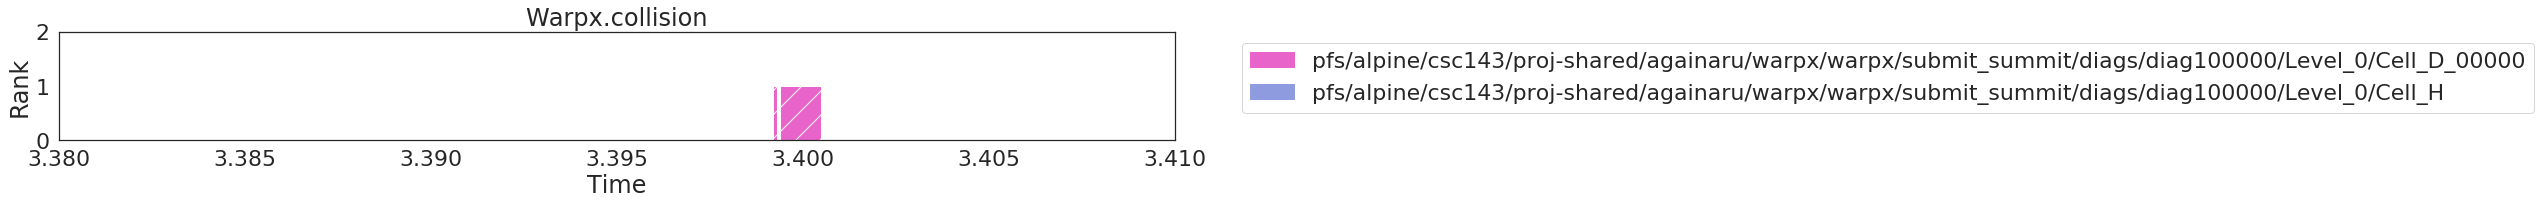

In [89]:
timeframe = [3.38, 3.41] # for all data timeframe = [0, max(df.End)]
df_filter = df[(df.Start >= timeframe[0]) & (df.End <= timeframe[1])]

sns.set(font_scale=2)
sns.set_style("white")
fig, ax = plt.subplots(figsize=(20,len(df.Rank.unique())))
plt.axes()
plt.gca().set_xlim(timeframe[0], timeframe[1])
plt.gca().set_ylim(0, len(df.Rank.unique()))

# Generate random colors for each file
color = {}
patch = []
for i in df_filter.File.unique():
    color[i] = np.random.rand(3)
    patch.append(mpatches.Patch(color=color[i], label=i))
    plt.legend(handles=patch, bbox_to_anchor=(1.05, 1), loc='upper left')

# plot the pattern
for i in df_filter[["Rank", "File", "Start", "End", "IOType"]].values:
    start = i[2]
    end = i[3]
    if i[4] == "write":
        rectangle = plt.Rectangle((start, i[0]), end - start, 1, fc=color[i[1]], hatch="/")
    else:
        rectangle = plt.Rectangle((start, i[0]), end - start, 1, fc=color[i[1]])
    plt.gca().add_patch(rectangle)

plt.gca().set_xlabel('Time')
plt.gca().set_ylabel('Rank')
plt.gca().set_title("%s%s" %(application_name.capitalize(), postfix_name))
plt.savefig("%s%s_dxt.png" %(application_name, postfix_name),
            bbox_inches = 'tight')
plt.show()